In [48]:
import sys, torch, numpy as np
import shutil, random
import matplotlib.pyplot as plt
from facenet_pytorch import InceptionResnetV1
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from collections import defaultdict
from PIL import Image
from torchvision import transforms
from tqdm import tqdm

In [3]:
print("exe:", sys.executable)
print("torch:", torch.__version__)
print("torchvision:", __import__("torchvision").__version__)
print("numpy:", np.__version__)
print("OK")

exe: c:\docs\face_recognition\.venv\Scripts\python.exe
torch: 2.2.2+cpu
torchvision: 0.17.2+cpu
numpy: 1.26.4
OK


In [4]:
data_dir = Path("data/Faces/Faces")

print('Exists:', data_dir.exists())
print('Images:', len(list(data_dir.glob('*.jpg'))))
print('People', len({p.stem.split("_")[0] for p in data_dir.glob('*.jpg')}))

Exists: True
Images: 2562
People 31


In [5]:
out_dir = Path('data/split')

if out_dir.exists():
    shutil.rmtree(out_dir)

(train_dir, val_dir, test_dir) = (out_dir/"train", out_dir/"val", out_dir/"test")

for d in (train_dir, val_dir, test_dir):
    d.mkdir(parents=True, exist_ok=True)


files = sorted(data_dir.glob('*jpg'))
labels = [p.stem.split('_')[0] for p in files]

X_train, X_temp, y_train, y_temp = train_test_split(files, labels, 
                                                   test_size=0.2,
                                                   random_state=42,
                                                   stratify = labels)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp,
                                                test_size=0.5,
                                                random_state=42,
                                                stratify = y_temp)

def copy_split(X, y, root):
    for p, person in zip(X, y):
        (root/person).mkdir(parents = True, exist_ok=True)
        shutil.copy2(p, root/person/p.name)

copy_split(X_train, y_train, train_dir)
copy_split(X_val, y_val, val_dir)
copy_split(X_test, y_test, test_dir)

print("Total:", len(files), "People:", len(set(labels)))
print("Train:", len(X_train), "Val:", len(X_val), "Test:", len(X_test))
print("Train folders:", len([p for p in train_dir.iterdir() if p.is_dir()]))
print("Val folders:", len([p for p in val_dir.iterdir() if p.is_dir()]))
print("Test folders:", len([p for p in test_dir.iterdir() if p.is_dir()]))

Total: 2562 People: 31
Train: 2049 Val: 256 Test: 257
Train folders: 31
Val folders: 31
Test folders: 31


In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cpu


In [39]:
people = sorted([p.name for p in train_dir.iterdir() if p.is_dir()])
print(len(people))
print(people)

31
['Akshay Kumar', 'Alexandra Daddario', 'Alia Bhatt', 'Amitabh Bachchan', 'Andy Samberg', 'Anushka Sharma', 'Billie Eilish', 'Brad Pitt', 'Camila Cabello', 'Charlize Theron', 'Claire Holt', 'Courtney Cox', 'Dwayne Johnson', 'Elizabeth Olsen', 'Ellen Degeneres', 'Henry Cavill', 'Hrithik Roshan', 'Hugh Jackman', 'Jessica Alba', 'Kashyap', 'Lisa Kudrow', 'Margot Robbie', 'Marmik', 'Natalie Portman', 'Priyanka Chopra', 'Robert Downey Jr', 'Roger Federer', 'Tom Cruise', 'Vijay Deverakonda', 'Virat Kohli', 'Zac Efron']


In [38]:
unknown_ids = {
    "Alia Bhatt",
    "Camila Cabello",
    "Hugh Jackman",
    "Marmik",
    "Virat Kohli"
}

In [40]:
model = InceptionResnetV1(pretrained='vggface2').eval().to(device)

preprocess = transforms.Compose([
    transforms.Resize((160, 160)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

out_path = Path('model')
out_path.mkdir(exist_ok=True)
gallery_file = out_path/"gallery.npz"

def embed_one(img_path: Path):
    img = Image.open(img_path).convert("RGB")
    x = preprocess(img).unsqueeze(0).to(device)
    with torch.no_grad():
        e = model(x).cpu().numpy()[0]
    e = e / (np.linalg.norm(e) + 1e-12)
    return e

names = []
templates = []

for person_dir in sorted([p for p in train_dir.iterdir() if p.is_dir()]):

    if person_dir.name in unknown_ids:
        continue  

    embs = []
    for img_path in person_dir.glob("*.jpg"):
        try:
            embs.append(embed_one(img_path))
        except Exception:
            pass

    if len(embs) == 0:
        continue

    template = np.mean(np.stack(embs), axis=0)
    template /= (np.linalg.norm(template) + 1e-12)

    names.append(person_dir.name)
    templates.append(template)

names = np.array(names, dtype=object)
templates = np.stack(templates)

np.savez(gallery_file, names=names, templates=templates)
print("Saved:", gallery_file)
print("Gallery identities:", len(names), "| template shape:", templates.shape)

Saved: model\gallery.npz
Gallery identities: 26 | template shape: (26, 512)


In [41]:
data = np.load("model/gallery.npz", allow_pickle=True)
names = data["names"]
templates = data['templates']

print('Loaded identities:', len(names))

Loaded identities: 26


In [42]:
def recognize(img_path, threshold = 0.45):
    q = embed_one(Path(img_path))

    sims = np.dot(templates, q)
    best_id = int(np.argmax(sims))
    best_score = float(sims[best_id])

    if best_score < threshold:
        return "Unknown", best_score
    
    return str(names[best_id]), best_score

In [43]:
name, score = recognize('data/Faces/Faces/Amitabh Bachchan_44.jpg')
print("Prediction:", name)
print("Similarity:", score)

Prediction: Amitabh Bachchan
Similarity: 0.9246437549591064


In [44]:
val_embs = []
val_labels = []
for person_dir in sorted([p for p in val_dir.iterdir() if p.is_dir()]):
    true_name = person_dir.name
    for img_path in person_dir.glob("*.jpg"):
        try:
            val_embs.append(embed_one(img_path))
            val_labels.append(true_name)
        except Exception:
            pass

val_embs = np.stack(val_embs)
val_labels = np.array(val_labels)

print("VAL embeddings:", val_embs.shape)

VAL embeddings: (256, 512)


In [45]:
sims = val_embs @ templates.T

print("Similarity matrix:", sims.shape)

Similarity matrix: (256, 26)


In [46]:
def find_best_threshold(sims, labels, names, unknown_ids):
    thresholds = np.linspace(0.2, 0.95, 76)

    best_thr = None
    best_key = None

    for thr in thresholds:
        known_total = known_correct = 0
        unk_total = unk_correct = 0

        for i, true_name in enumerate(labels):
            best_id = int(np.argmax(sims[i]))
            best_score = float(sims[i, best_id])

            pred = "Unknown" if best_score < thr else str(names[best_id])

            if true_name in unknown_ids:
                unk_total += 1
                if pred == "Unknown":
                    unk_correct += 1
            else:
                known_total += 1
                if pred == true_name:
                    known_correct += 1

        known_acc = known_correct / known_total if known_total else 0.0
        unk_acc = unk_correct / unk_total if unk_total else 0.0

        key = (unk_acc, known_acc)

        if best_key is None or key > best_key:
            best_key = key
            best_thr = float(thr)

    print("Best threshold (open-set):", best_thr)
    print("VAL unknown detection:", best_key[0])
    print("VAL known accuracy:", best_key[1])
    return best_thr

best_thr = find_best_threshold(sims, val_labels, names, unknown_ids)

Best threshold (open-set): 0.48000000000000004
VAL unknown detection: 1.0
VAL known accuracy: 0.9954545454545455


In [47]:
test_embs = []
test_labels = []
for person_dir in sorted([p for p in test_dir.iterdir() if p.is_dir()]):
    true_name = person_dir.name
    for img_path in person_dir.glob("*.jpg"):
        try:
            test_embs.append(embed_one(img_path))
            test_labels.append(true_name)
        except Exception:
            pass

test_embs = np.stack(test_embs)
test_labels = np.array(test_labels)

test_sims = test_embs @ templates.T

def evaluate_on_test(sims, labels, names, unknown_ids, thr):
    known_total = known_correct = 0
    unk_total = unk_correct = 0

    for i, true_name in enumerate(labels):
        best_id = int(np.argmax(sims[i]))
        best_score = float(sims[i, best_id])
        pred = "Unknown" if best_score < thr else str(names[best_id])

        if true_name in unknown_ids:
            unk_total += 1
            if pred == "Unknown":
                unk_correct += 1
        else:
            known_total += 1
            if pred == true_name:
                known_correct += 1

    known_acc = known_correct / known_total if known_total else 0.0
    unk_acc = unk_correct / unk_total if unk_total else 0.0
    return known_acc, unk_acc, known_total, unk_total

known_acc, unk_acc, kt, ut = evaluate_on_test(test_sims, test_labels, names, unknown_ids, thr=0.48)
print("TEST known accuracy:", known_acc, "on", kt, "images")
print("TEST unknown detection:", unk_acc, "on", ut, "images")

TEST known accuracy: 0.9909502262443439 on 221 images
TEST unknown detection: 0.9444444444444444 on 36 images


AUC: 0.9993715434891906
At threshold: 0.48000000000000004
Known accepted (TPR): 0.995475113122172
Unknown accepted (FPR): 0.1388888888888889


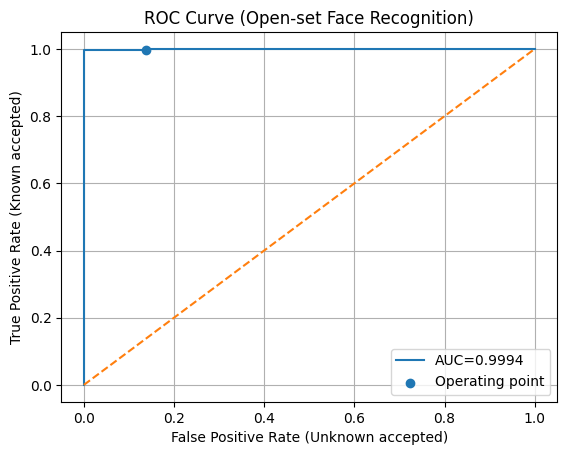

In [50]:
y_true = np.array([0 if name in unknown_ids else 1 for name in test_labels])

y_score = test_sims.max(axis=1)

fpr, tpr, thresholds = roc_curve(y_true, y_score)
roc_auc = auc(fpr, tpr)

print("AUC:", roc_auc)


thr_value = best_thr
idx = np.argmin(np.abs(thresholds - thr_value))
print("At threshold:", thr_value)
print("Known accepted (TPR):", tpr[idx])
print("Unknown accepted (FPR):", fpr[idx])

plt.figure()
plt.plot(fpr, tpr, label=f"AUC={roc_auc:.4f}")
plt.plot([0,1],[0,1],'--')
plt.scatter([fpr[idx]],[tpr[idx]], label="Operating point")
plt.xlabel("False Positive Rate (Unknown accepted)")
plt.ylabel("True Positive Rate (Known accepted)")
plt.title("ROC Curve (Open-set Face Recognition)")
plt.legend()
plt.grid(True)
plt.show()